In [1]:
import pandas as pd
pd.set_option('display.max_columns', False)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

## Exploration of the train set

In [2]:
data = pd.read_json('train.json')
data.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


#### Sanity check
Let's see whether there are some missing values:

In [3]:
data.isnull().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
interest_level     0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
dtype: int64

There seems not to be missing values!
Be careful however that there are some "hidden" missing values, e.g. for descrption column, where instead of a text there is a blank: 

In [4]:
data.description[10000]

'        '

In [5]:
# Cleaning the description variable
data['description'] = data['description'].apply(lambda x: x.lstrip().rstrip())
print('There are {} missing descriptions'.format(data.description[data.description == ''].shape[0]))

There are 3333 missing descriptions


In [6]:
data.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'listing_id', 'longitude', 'manager_id', 'photos', 'price',
       'street_address'],
      dtype='object')

We wish to predict the interest level of a given appartment. Let's first have a look at the repartition of interest levels: 

#### Interest Levels

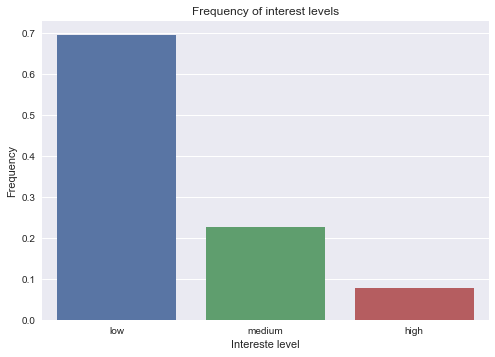

In [7]:
sorted_count = data.interest_level.value_counts() / len(data)
sns.barplot(y=sorted_count.values, x=sorted_count.index)
plt.title('Frequency of interest levels')
plt.xlabel('Intereste level')
plt.ylabel('Frequency')
plt.show()

Most appartments receive a low interest level, and only a few have a high level of interest. Which feature can explain this interest? Let's have an exploratory approach and test the given variables: 

#### Number of bathrooms

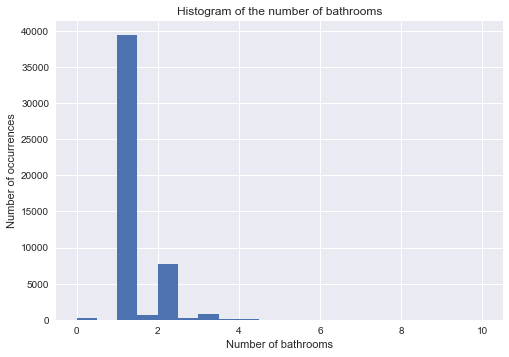

In [8]:
plt.hist(data.bathrooms, bins=20)
plt.ylabel('Number of occurrences')
plt.xlabel('Number of bathrooms')
plt.title('Histogram of the number of bathrooms')
plt.show()

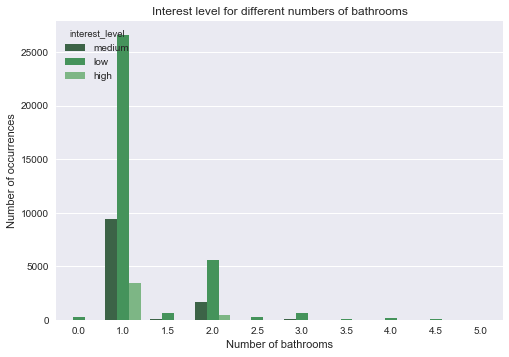

In [9]:
sns.countplot(x="bathrooms", data=data[data.bathrooms < 5.5], palette="Greens_d", hue='interest_level', orient='v')
plt.title('Interest level for different numbers of bathrooms')
plt.ylabel('Number of occurrences')
plt.xlabel('Number of bathrooms')
plt.show()

It is not quite clear what 1.5 bathrooms means, so I will take only natural numbers: 

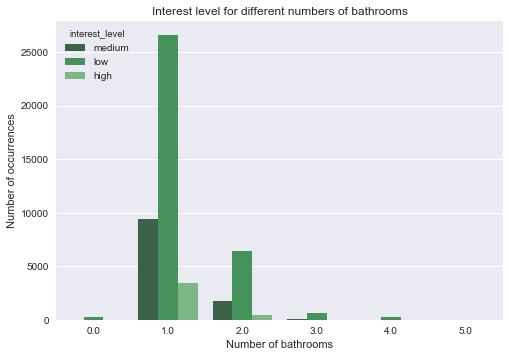

In [10]:
# Take round values
data['bathrooms'] = data['bathrooms'].apply(lambda x: np.round(x))

sns.countplot(x="bathrooms", data=data[data.bathrooms < 5.5], palette="Greens_d", hue='interest_level', orient='v')
plt.title('Interest level for different numbers of bathrooms')
plt.ylabel('Number of occurrences')
plt.xlabel('Number of bathrooms')
plt.show()

#### Number of bedrooms

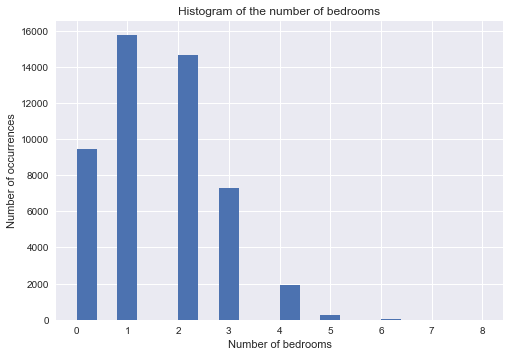

In [11]:
plt.hist(data.bedrooms, bins=20)
plt.ylabel('Number of occurrences')
plt.xlabel('Number of bedrooms')
plt.title('Histogram of the number of bedrooms')
plt.show()

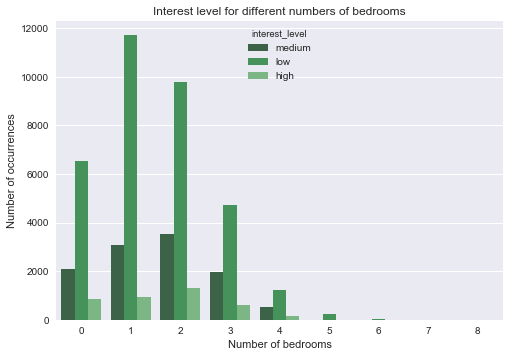

In [12]:
sns.countplot(x="bedrooms", data=data, palette="Greens_d", hue='interest_level', orient='v')
plt.title('Interest level for different numbers of bedrooms')
plt.ylabel('Number of occurrences')
plt.xlabel('Number of bedrooms')
plt.show()

Appartments with 2 bedrooms seem to get most interest.

#### Price

In [13]:
data.price.describe()

count    4.935200e+04
mean     3.830174e+03
std      2.206687e+04
min      4.300000e+01
25%      2.500000e+03
50%      3.150000e+03
75%      4.100000e+03
max      4.490000e+06
Name: price, dtype: float64

There seems to be large outliers:

In [14]:
size = len(data[data.price > 10000].interest_level) / len(data)
print('{}% of the data are appartments with prices superior to $10 000'.format(size*100))

1.7790565731885235% of the data are appartments with prices superior to $10 000


In [15]:
# We only keep appartments with prices smaller than $10 000
data = data[data.price < 10000]

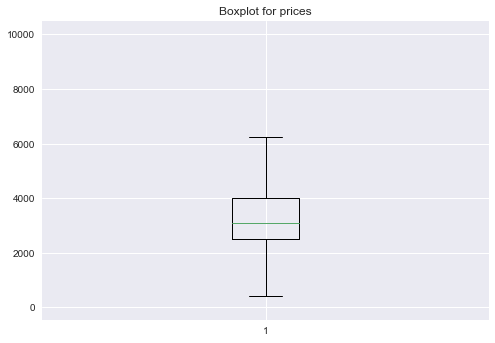

In [16]:
plt.boxplot(data.price.reset_index().price)
plt.title('Boxplot for prices')
plt.show()

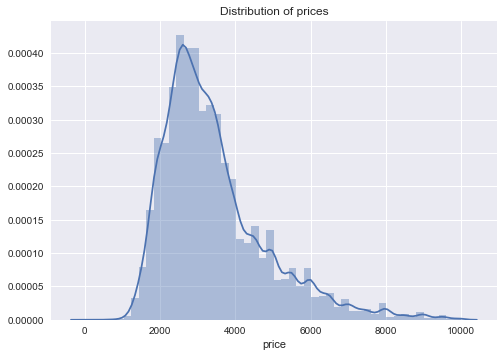

In [17]:
sns.distplot(data.price)
plt.title('Distribution of prices')
plt.show()

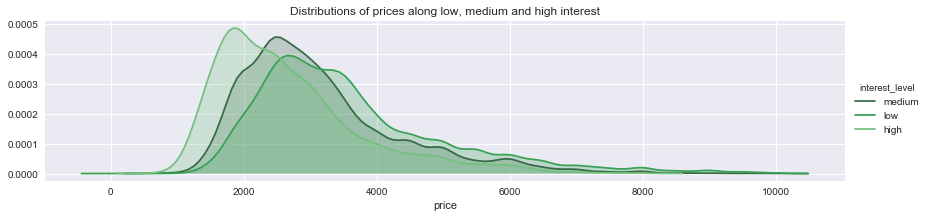

In [18]:
facet = sns.FacetGrid(data, hue="interest_level",aspect=4, palette="Greens_d")
facet.map(sns.kdeplot,'price',shade= True)
plt.title('Distributions of prices along low, medium and high interest')
facet.add_legend()
plt.show()

Th data confirms the intuition that the interest is favored for smaller prices!

In [19]:
data.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'listing_id', 'longitude', 'manager_id', 'photos', 'price',
       'street_address'],
      dtype='object')

#### Number of features
The variable "features" gives tags for appartments.

In [32]:
data['number_of_features'] = data['features'].apply(lambda x: len(x))

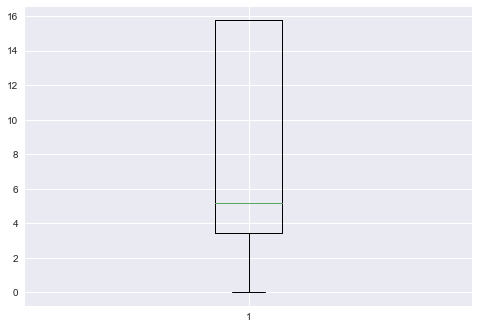

In [33]:
plt.boxplot(data.number_of_features.describe().reset_index().number_of_features, showfliers=False)
plt.show()

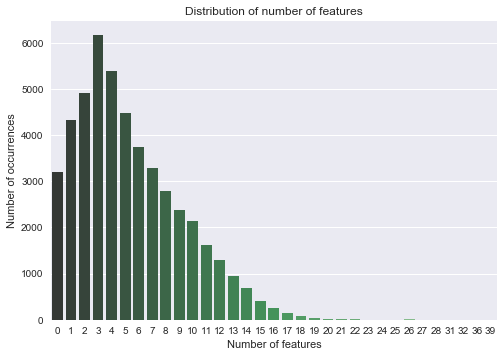

In [34]:
sns.countplot(x="number_of_features", data=data, palette="Greens_d", orient='v')
plt.title('Distribution of number of features')
plt.ylabel('Number of occurrences')
plt.xlabel('Number of features')
plt.show()

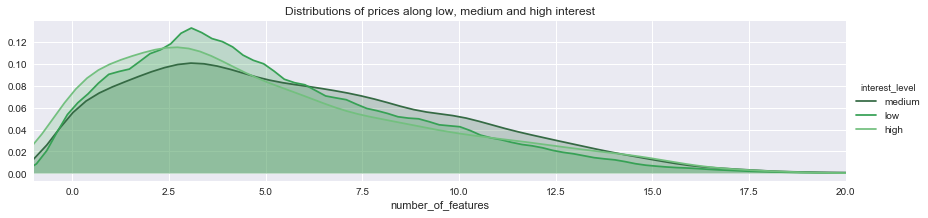

In [35]:
facet = sns.FacetGrid(data, hue="interest_level",aspect=4, palette="Greens_d")
facet.map(sns.kdeplot,'number_of_features',shade= True)
plt.title('Distributions of prices along low, medium and high interest')
facet.add_legend()
plt.xlim([-1, 20])
plt.show()

High interest appartments seem to have fewer features, although this is not straightforward.

#### Date of creation

In [23]:
from datetime import datetime, date, time, timedelta
data['created'] = data['created'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [24]:
data['creation_year'] = data['created'].apply(lambda x: x.year)
data['creation_month'] = data['created'].apply(lambda x: x.month)
data['creation_day'] = data['created'].apply(lambda x: x.weekday())
data['creation_hour'] = data['created'].apply(lambda x: x.hour)

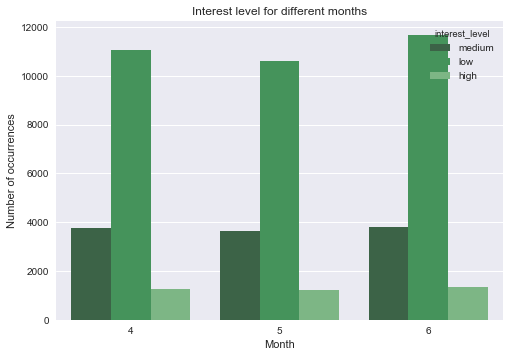

In [25]:
sns.countplot(x="creation_month", data=data, palette="Greens_d", hue='interest_level', orient='v')
plt.title('Interest level for different months')
plt.ylabel('Number of occurrences')
plt.xlabel('Month')
plt.show()

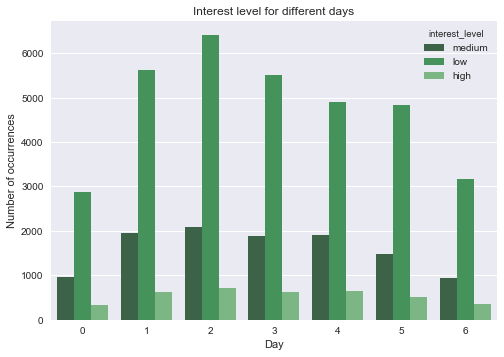

In [26]:
sns.countplot(x="creation_day", data=data, palette="Greens_d", hue='interest_level', orient='v')
plt.title('Interest level for different days')
plt.ylabel('Number of occurrences')
plt.xlabel('Day')
plt.show()

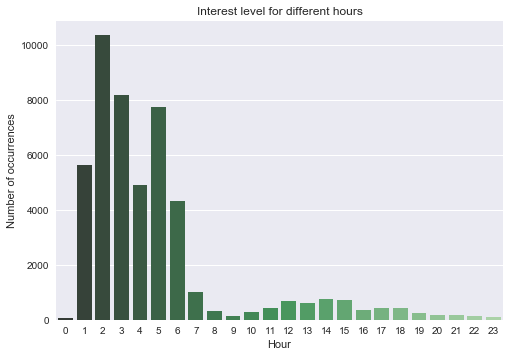

In [27]:
sns.countplot(x="creation_hour", data=data, palette="Greens_d", orient='v')
plt.title('Interest level for different hours')
plt.ylabel('Number of occurrences')
plt.xlabel('Hour')
plt.show()

#### Manager

How many offers a manager publish?

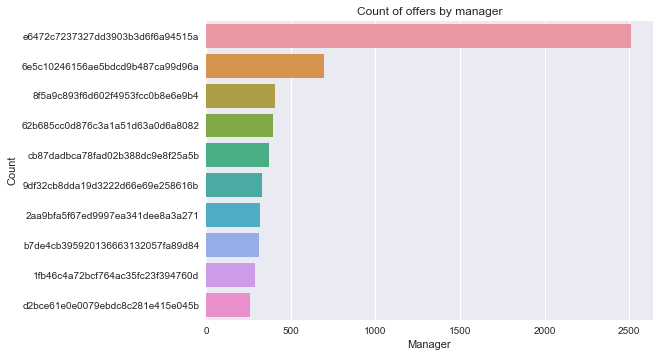

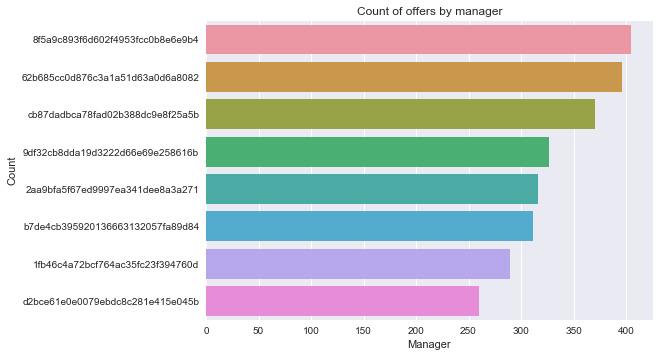

In [79]:
sorted_count = data.manager_id.value_counts()[:10]
sns.barplot(x=sorted_count.values, y=sorted_count.index)
plt.title('Count of offers by manager')
plt.xlabel('Manager')
plt.ylabel('Count')
plt.show()

sorted_count = data.manager_id.value_counts()[2:10]
sns.barplot(x=sorted_count.values, y=sorted_count.index)
plt.title('Count of offers by manager')
plt.xlabel('Manager')
plt.ylabel('Count')
plt.show()

How many offers the manager has published before? Is she very active or not?

In [53]:
data.created[10]

Timestamp('2016-06-24 07:54:24')

In [55]:
data['cumulative_manager'] = data.sort_values('created').assign(x=1).groupby('manager_id')['x'].cumsum()[data.index]

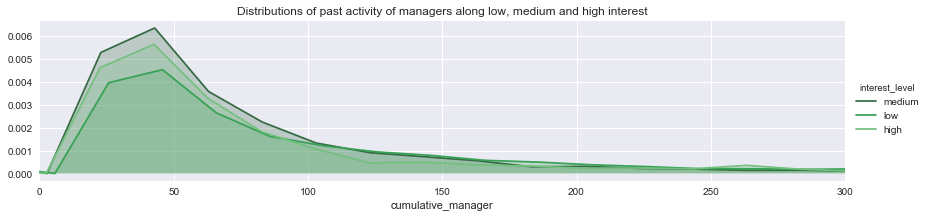

In [60]:
facet = sns.FacetGrid(data, hue="interest_level",aspect=4, palette="Greens_d")
facet.map(sns.kdeplot,'cumulative_manager',shade= True)
plt.title('Distributions of past activity of managers along low, medium and high interest')
facet.add_legend()
plt.xlim([0, 300])
plt.show()

It appears that there is no clear link between the "maturity" of the manager with the interest in the appartment.

Is there a link between the sum of prices of past offers from the manager with the interest?

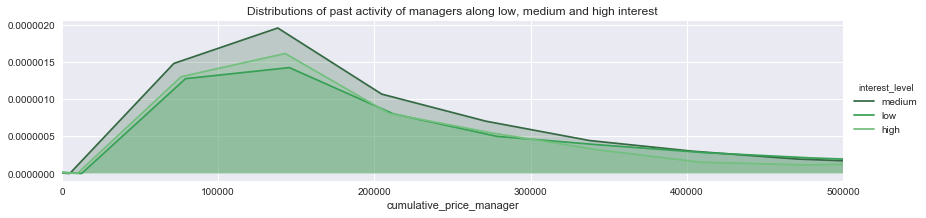

In [75]:
data['cumulative_price_manager'] = data.sort_values('created').groupby('manager_id')['price'].cumsum()[data.index]

facet = sns.FacetGrid(data, hue="interest_level",aspect=4, palette="Greens_d")
facet.map(sns.kdeplot,'cumulative_price_manager',shade= True)
plt.title('Distributions of past activity of managers along low, medium and high interest')
facet.add_legend()
plt.xlim([0, 500000])
plt.show()

The answer is no.

#### Building
Same question for the building?

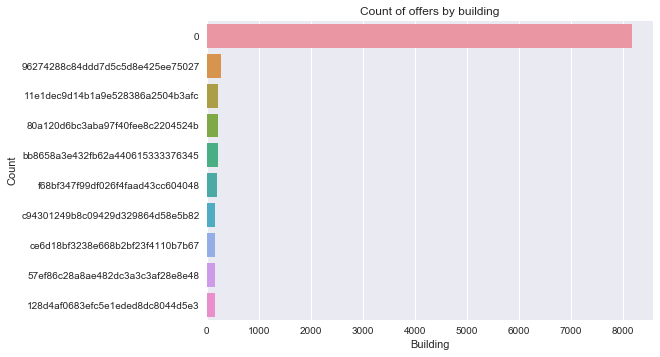

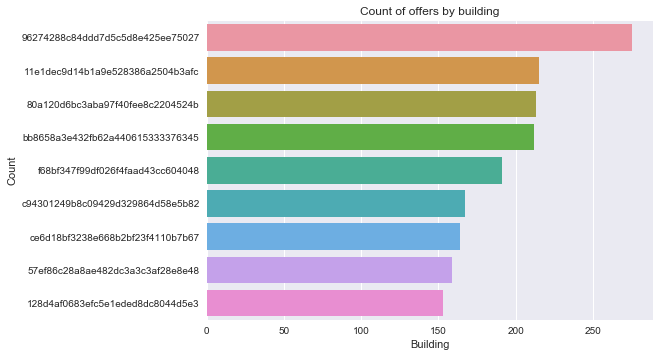

In [80]:
sorted_count = data.building_id.value_counts()[:10]
sns.barplot(x=sorted_count.values, y=sorted_count.index)
plt.title('Count of offers by building')
plt.xlabel('Building')
plt.ylabel('Count')
plt.show()

sorted_count = data.building_id.value_counts()[1:10]
sns.barplot(x=sorted_count.values, y=sorted_count.index)
plt.title('Count of offers by building')
plt.xlabel('Building')
plt.ylabel('Count')
plt.show()

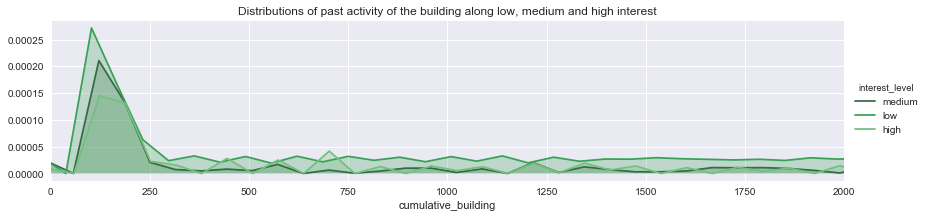

In [92]:
data['cumulative_building'] = data.sort_values('created').assign(x=1).groupby('building_id')['x'].cumsum()[data.index]

facet = sns.FacetGrid(data, hue="interest_level",aspect=4, palette="Greens_d")
facet.map(sns.kdeplot,'cumulative_building',shade= True)
plt.title('Distributions of past activity of the building along low, medium and high interest')
facet.add_legend()
plt.xlim([0, 2000])
plt.show()

Once again, there seems not to be a discriminant link between the past activity of the building and the interest level.

#### Geospatial data

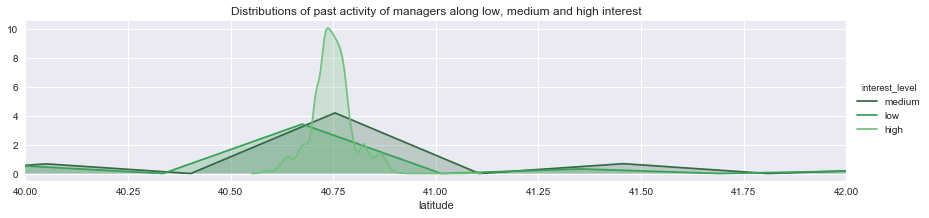

In [104]:
facet = sns.FacetGrid(data, hue="interest_level",aspect=4, palette="Greens_d")
facet.map(sns.kdeplot,'latitude',shade= True)
plt.title('Distributions of past activity of managers along low, medium and high interest')
facet.add_legend()
plt.xlim([40, 42])
plt.show()

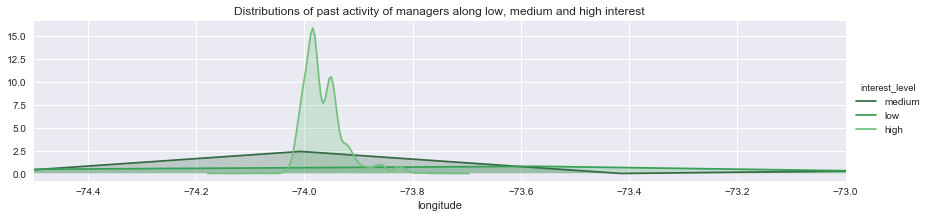

In [105]:
facet = sns.FacetGrid(data, hue="interest_level",aspect=4, palette="Greens_d")
facet.map(sns.kdeplot,'longitude',shade= True)
plt.title('Distributions of past activity of managers along low, medium and high interest')
facet.add_legend()
plt.xlim([-74.5, -73])
plt.show()

There seems to be a clear link between the location and the interset level! The low and medium interest are quite largely spread, whereas it is well punctual for the high interest appartments! But in fact, nthis is due to outliers:

In [145]:
data[(data.latitude > 41) | (data.latitude < 40.5)].interest_level.value_counts()

low       35
medium     3
high       2
Name: interest_level, dtype: int64

Let's focus on the latitudes and longitudes from NYC:

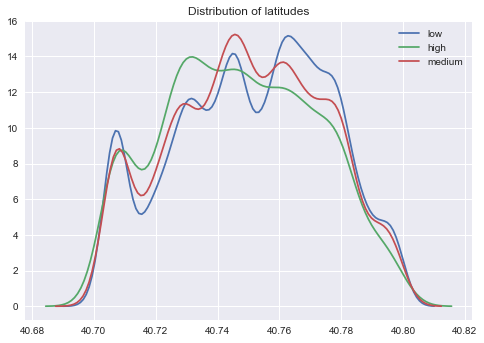

In [154]:
a = data[(data.latitude > 40.7) & (data.latitude < 40.8)]

sns.kdeplot(a.latitude[a.interest_level == 'low'], label='low')
sns.kdeplot(a.latitude[a.interest_level == 'high'], label = 'high')
sns.kdeplot(a.latitude[a.interest_level == 'medium'], label = 'medium')

plt.title('Distribution of latitudes')
# plt.xlim([38, 44])
plt.show()

The distinction is not straightforward, but appartment with smaller latitude tend to have better interest level than appartments with greater latitudes, which may be linked to social issues and boroughs.

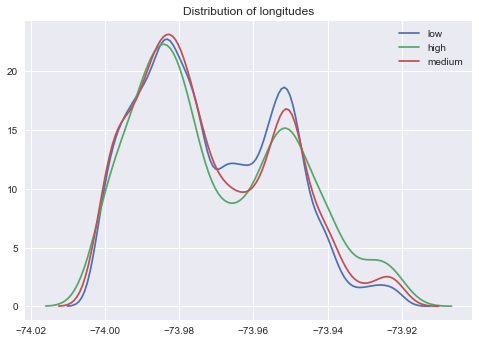

In [153]:
a = data[(data.longitude > -74.0025) & (data.longitude < -73.92)]

sns.kdeplot(a.longitude[a.interest_level == 'low'], label='low')
sns.kdeplot(a.longitude[a.interest_level == 'high'], label = 'high')
sns.kdeplot(a.longitude[a.interest_level == 'medium'], label = 'medium')
plt.title('Distribution of longitudes')
plt.show()

The longitudes do not provide any clear discrimnative information. However, this graph show a clear distinction between appartments located on both sides of Verrazano-Narrow Bridge, with fewer appartments offers because of the bay!

#### Type of adress

In [190]:
def type_street(x):
    if ('boulevard' in x.lower()) | ('blvd' in x.lower()):
        return 'boulevard'
    elif ('street' in x.lower()) | ('St' in x):
        return 'street'
    elif ('Ave' in x) | ('avenue' in x.lower()):
        return 'avenue'
    elif 'square' in x.lower():
        return 'square'
    elif 'place' in x.lower():
        return 'place'
    elif 'terrace' in x.lower():
        return 'terrace'
    elif 'road' in x.lower():
        return 'road'
    elif 'lane' in x.lower():
        return 'lane'
    elif 'park' in x.lower():
        return 'park'
    else:
        return 'other'

In [191]:
data['type_street'] = data['street_address'].apply(type_street)

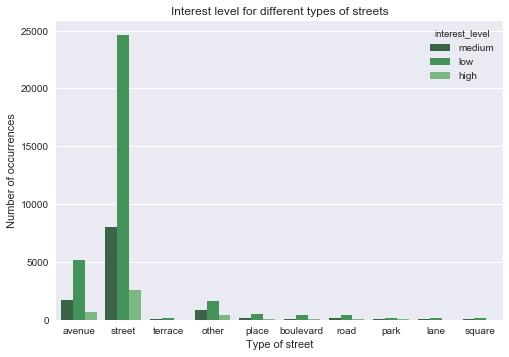

In [192]:
sns.countplot(x="type_street", data=data, palette="Greens_d", hue='interest_level', orient='v')
plt.title('Interest level for different types of streets')
plt.ylabel('Number of occurrences')
plt.xlabel('Type of street')
plt.show()

#### Size of the description

In [193]:
data.description[10]

"A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy These Following Apartment Features As You Rent Here? Modern Designed Bathroom w/ a Deep Spa Soaking Tub? Room to Room AC/Heat? Real Oak Hardwood Floors? Rain Forest Shower Head? SS steel Appliances w/ Chef Gas Cook Oven & LG Fridge? washer /dryer in the apt? Cable Internet Ready? Granite Counter Top Kitchen w/ lot of cabinet storage spaceIt's Just A Few blocks To L Train<br /><br />Don't miss out!<br /><br />We have several great apartments in the immediate area.<br /><br />For additional information 687-878-2229<p><a  website_redacted"

We need to clean the html

In [204]:
from bs4 import BeautifulSoup
data['clean_description'] = data['description'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)


In [207]:
data['description_size'] = data['clean_description'].apply(lambda x: len(x))

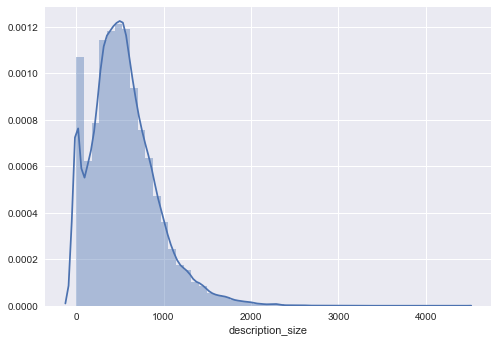

In [212]:
sns.distplot(data.description_size)
plt.show()

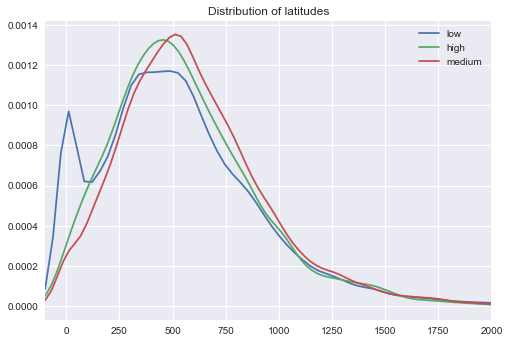

In [217]:
sns.kdeplot(data.description_size[data.interest_level == 'low'], label='low')
sns.kdeplot(data.description_size[data.interest_level == 'high'], label = 'high')
sns.kdeplot(data.description_size[data.interest_level == 'medium'], label = 'medium')

plt.title('Distribution of latitudes')
plt.xlim([-100, 2000])
plt.show()

We see that description with very low size are likely to be of no interest. After that, we see that high interest offers have slightly lower sizes of descriptions than medium. However, the discrimnation here is not clear.

#### Number of photos

In [220]:
data['photos_number'] = data['photos'].apply(lambda x: len(x))

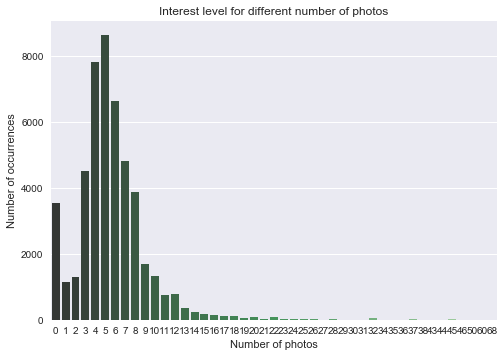

In [232]:
sns.countplot(x="photos_number", data=data, palette="Greens_d", orient='v')
plt.title('Interest level for different number of photos')
plt.ylabel('Number of occurrences')
plt.xlabel('Number of photos')
plt.show()

#### End of Exploration
Please share comments and suggestions!